# Описание
В настоящее время количество выходящих в течение года научных публикаций велико и растёт экспоненциально во многих областях, в связи с чем открывается простор для создания автоматических инструментов, помогающих в поиске и обработке информации. В частности, веб-сервис [PubTrends](https://pubtrends.net/) позволяет взглянуть на множество статей, соответствующих поисковому запросу, как на единое целое, выделяя подразделы научных направлений, динамику их развития и тем самым структурируя результаты выдачи.
В рамках текущего проекта предлагается добавить в список возможностей сервиса извлечение численных показателей, а также визуализацию результатов и возможность фильтрации статей на основе извлеченных значений. Такая функциональность может быть полезна, например, в биомедицинской литературе для поиска статей с большим количеством испытуемых, а в технической - для получения представления о получаемых значений целевой метрики в рамках различных задач.
Для извлечения численных показателей из текста уже существуют инструменты, такие как [grobid-quantities](https://grobid-quantities.readthedocs.io/en/latest/) или [marve](https://arxiv.org/pdf/1710.04312.pdf). Фокус этой практики будет обращен именно на агрегацию информации из множества статей и использование этой информации для фильтрации статей. Первоначально разработка будет вестись в рамках Jupyter Notebook, при успешном выполнении задач планируется интеграция модуля в существующий веб-сервис.

*Почему вам интересен этот проект?*

В моей научной деятельности, которая завязана на эксперименте и моделировании, численные величины часто определяют суть работы. Например, эксперименты при разных температурах (от комнатной до гелиевой) могут кардинально отличаться по используемым методам и применяемым моделям. Такая информация не всегда явно выделяется словесным описанием, и было бы удобно иметь инструмент для её извлечения и классификации работ по некоторым численным показателям. Вопросы к цифрам в публикациях коллег по области возникают достаточно часто в моей работе, поэтому мне было бы крайне интересно принять участие в таком проекте, довести его до реализации и в перспективе пользоваться таким инструментом.


#Задача 1
Задачи

Установить [grobid-quantities](https://grobid-quantities.readthedocs.io/en/latest/)

Скачать CSV файл с информацией о статьях по [ссылке](https://drive.google.com/file/d/1d3NJbq7EInZYl8Q5Pb7YfAwQUVxZ9FdE/view?usp=sharing).
Загрузить данные из CSV. Файл содержит две колонки: PMID (идентификатор статьи в базе Pubmed) и abstract (текст аннотации).

Используя REST API запущенного локально сервиса grobid-quantities, извлечь все численные показатели из аннотаций статей. В рамках этого задания достаточно поддержать только тип значений value (см. [документацию](https://grobid-quantities.readthedocs.io/en/latest/restAPI.html#response-description) grobid-quantities).

Построить гистограмму извлеченных значений, относящихся к слову ‘accuracy’ в текстах аннотаций.

In [1]:
# %cd /content/drive/MyDrive/CSC/2022_spring_internship/JB_SHK2
!pip install -r requirements.txt 

     |████████████████████████████████| 11.7 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 186 kB/s eta 0:00:01
     |████████████████████████████████| 503 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 2.9 MB/s eta 0:00:01
  Created wheel for grobid-quantities-client: filename=grobid_quantities_client-0.2.1-py3-none-any.whl size=6870 sha256=f2ab3dd37b8b434d80e35cfdd14c8d4be1356bcd5a2ddb0d5e1c86f297abbb2a
  Stored in directory: /home/oduwancheekee/.cache/pip/wheels/c9/ba/18/2ba25df32218144afbe360dbb7068e488eca093f07ce3e7687
  Created wheel for zenlog: filename=zenlog-1.1-py3-none-any.whl size=2357 sha256=05b69182b06c31b09ccaf1150e8d0915afe957d5b82f3343f6e37de02fa65133
  Stored in directory: /home/oduwancheekee/.cache/pip/wheels/3a/fc/06/20fc224824dd6ee18498855665cb85555be8527bbccd0b607f
Successfully built grobid-quantities-client zenlog


In [ ]:
import grobid_quantities.quantities 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_orig = pd.read_csv('2022_JBR_Spring_Internship_Test_Data.csv')
server_url = 'http://localhost:8060/service/'

from grobid_quantities.quantities import QuantitiesClient
client = QuantitiesClient(apiBase=server_url)

In [347]:
# извлечь все численные показатели из аннотаций статей
# В рамках этого задания достаточно поддержать только тип значений value (см. документацию grobid-quantities).
# Построить гистограмму извлеченных значений, относящихся к слову ‘accuracy’ в текстах аннотаций.


# Извлекать 0<x<1 и спрашивать, если ли рядом (в этом предложении) слово "accurac", тогда считать
# df.abstract[10 1, 100 -3, 103, -3] to test
# 'accurac' in text[meas['measurementOffsets']['start'] +-100]

def retrieve_percentages(text):
    text = text.replace('\u2009', '').replace('\u202f', '').replace('\u200a', '') # deleting unicodes
                                                                                  # invoking response 500 
    data = client.process_text(text) 
    quants = []
    if data[0] != 200:
        print("response ", data[0])
        return None
    if 'measurements' not in data[1].keys():
        return []
    
    for meas in data[1]['measurements']:
        if (meas['type'] == 'value'
           and 'normalizedUnit' in meas['quantity'].keys()
           and meas['quantity']['normalizedUnit'] == {'name': 'one'}
           ):
            quant = meas['quantity']['normalizedQuantity']
            if quant >= 0 and quant <= 1: quants.append(quant)
    return quants

df_orig = pd.read_csv('2022_JBR_Spring_Internship_Test_Data.csv')
df_orig.loc[437, 'abstract'] = ''.join([
    'The average classification accuracy was 67.9% and 75.7% for covert and overt speech, ',
    'respectively; this was 5-10 % lower than the movement classification. The performance ',
    'of the combined movement-speech decoder was 61.9% and 67.7% (covert and overt), ',
    'but it is possible to have more classes available for control.'
]) # row 437 has broken markdown and fixed by the easiest way - manually 


df = df_orig

df['accuracy'] = ['accurac' in df.loc[i, 'abstract'] for i in range(len(df))]
df['percentage'] = [retrieve_percentages(df['abstract'][i]) for i in range(len(df))]
df

,PMID,abstract,accuracy,percentage
0,35103873,It has been a challenge for solving the motor ...,True,[]
1,35095410,The development of reliable assistive devices ...,False,[]
2,35093844,Identifying motor and mental imagery electroen...,True,[0.9952]
3,35090904,Brain computer interface (BCI) utilizes brain ...,True,"[0.7181, 0.8314]"
4,35088740,Brain-computer interface (BCI)-controlled func...,False,[]
...,...,...,...,...
1424,11482363,The electroencephalogram (EEG) is modified by ...,True,[]
1425,11204035,Electroencephalogram (EEG) recordings during r...,True,[0.14]
1426,10896191,We present an overview of our research into br...,False,[]
1427,10478710,EEG feedback studies demonstrate that human su...,True,[0.85]


/tmp/ipykernel_10131/3011367755.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for quants in df[df['accuracy'] == True][df['percentage'].str.len() != 0]['percentage']:


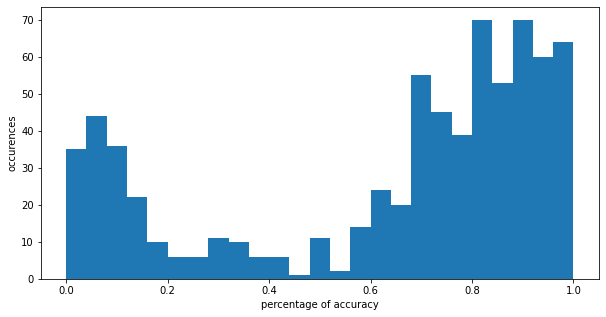

In [356]:
occurences = []
for quants in df[df['accuracy'] == True][df['percentage'].str.len() != 0]['percentage']:
    occurences += quants

plt.figure(figsize=(10,5))
plt.hist(occurences, 25)
plt.xlabel('percentage of accuracy')
plt.ylabel('occurences')
plt.show()